In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error
import numpy as np

# Note: The 'FileNotFoundError' occurred in cell N7UtsW76gFwt when trying to read 'sales.csv'.
# Please consider changing 'sales.csv' to '/content/stores_sales_forecasting.csv' in cell N7UtsW76gFwt to fix the error.

In [5]:
df = pd.read_csv("/content/stores_sales_forecasting.csv", encoding='latin1')
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
3,6,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600,7,0.00,14.1694
4,11,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,1706.1840,9,0.20,85.3092


In [7]:
df['Order Date'] = pd.to_datetime(df['Order Date'])

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2121 entries, 0 to 2120
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         2121 non-null   int64         
 1   Order ID       2121 non-null   object        
 2   Order Date     2121 non-null   datetime64[ns]
 3   Ship Date      2121 non-null   object        
 4   Ship Mode      2121 non-null   object        
 5   Customer ID    2121 non-null   object        
 6   Customer Name  2121 non-null   object        
 7   Segment        2121 non-null   object        
 8   Country        2121 non-null   object        
 9   City           2121 non-null   object        
 10  State          2121 non-null   object        
 11  Postal Code    2121 non-null   int64         
 12  Region         2121 non-null   object        
 13  Product ID     2121 non-null   object        
 14  Category       2121 non-null   object        
 15  Sub-Category   2121 n

In [15]:
monthly_sales = df.groupby(pd.Grouper(key='Order Date', freq='M'))['Sales'].sum().reset_index()
monthly_sales.head()

/tmp/ipython-input-3831028977.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df.groupby(pd.Grouper(key='Order Date', freq='M'))['Sales'].sum().reset_index()


,Order Date,Sales
0,2014-01-31,6242.525
1,2014-02-28,1839.658
2,2014-03-31,14573.956
3,2014-04-30,7944.837
4,2014-05-31,6912.787


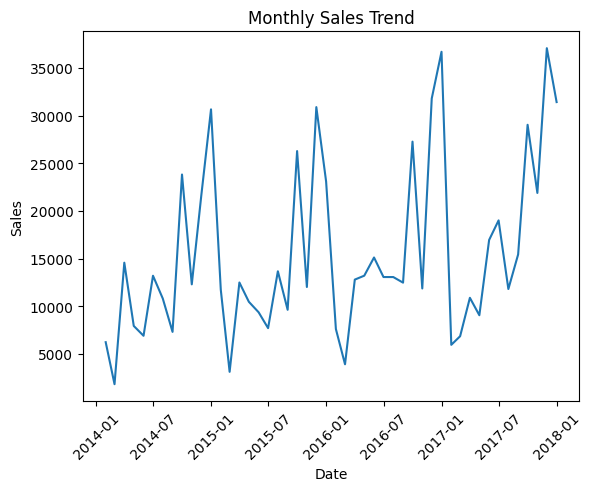

In [16]:
plt.figure()
plt.plot(monthly_sales['Order Date'], monthly_sales['Sales'])
plt.title("Monthly Sales Trend")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.xticks(rotation=45)
plt.show()

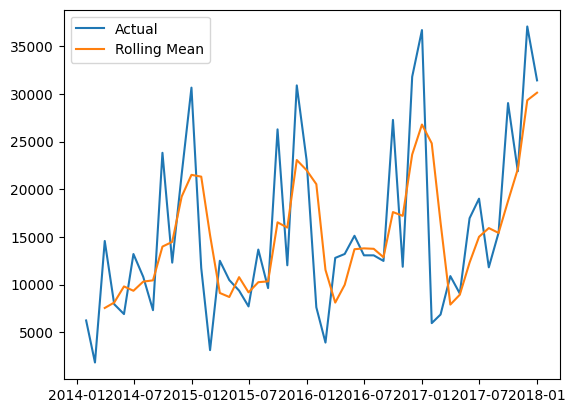

In [18]:
monthly_sales['Rolling_Mean'] = monthly_sales['Sales'].rolling(window=3).mean()

plt.figure()
plt.plot(monthly_sales['Order Date'], monthly_sales['Sales'], label='Actual')
plt.plot(monthly_sales['Order Date'], monthly_sales['Rolling_Mean'], label='Rolling Mean')
plt.legend()
plt.show()

In [19]:
train_size = int(len(monthly_sales) * 0.8)

train = monthly_sales.iloc[:train_size]
test = monthly_sales.iloc[train_size:]


In [20]:
model = ExponentialSmoothing(
    train['Sales'],
    trend='add',
    seasonal=None
)

model_fit = model.fit()


In [21]:
forecast = model_fit.forecast(steps=len(test))


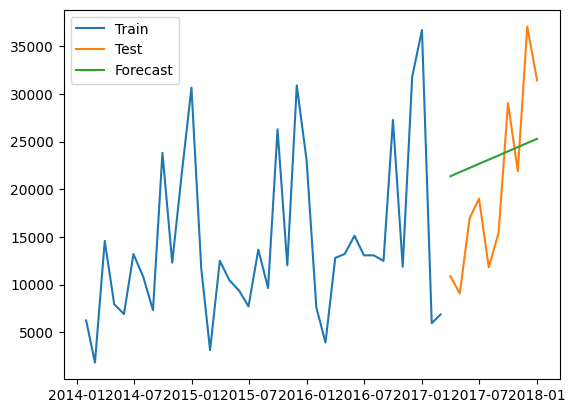

In [23]:
plt.figure()
plt.plot(train['Order Date'], train['Sales'], label='Train')
plt.plot(test['Order Date'], test['Sales'], label='Test')
plt.plot(test['Order Date'], forecast, label='Forecast')
plt.legend()
plt.show()

In [24]:
mae = mean_absolute_error(test['Sales'], forecast)
print("MAE:", mae)


MAE: 7741.294681773214


In [25]:
mape = np.mean(np.abs((test['Sales'] - forecast) / test['Sales'])) * 100
print("MAPE:", mape)


MAPE: 51.609559256547634


In [26]:
future_forecast = model_fit.forecast(steps=3)
print(future_forecast)


38    21355.325964
39    21791.558802
40    22227.791641
dtype: float64


In [28]:
forecast_df = pd.DataFrame({
    'Date': test['Order Date'],
    'Actual_Sales': test['Sales'],
    'Forecasted_Sales': forecast
})

forecast_df.to_csv("forecast_output.csv", index=False)